# FOOOF - Tutorial

FOOOF (fitting oscillations & one over f) is a module to fit neural power spectra.  


In [1]:
%matplotlib inline
import numpy as np

# Temporary path BS to add FOOOF module to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
# Import the FOOOF object
from fooof import FOOOF

## Model Description

In FOOOF, an electrophysiological PSD is fit as a combination of the background process (the 'slope' of the arythmic, background 1/f), upon which there may be oscillations - frequency regions in which there are 'bumps', with power over and above this background process.  

The background fit is a log-lorentzian, fit on the semilog PSD (linear frequencies and log10 power values). 

The log-lorentzian is of the form:

$$psd = 10^a * \frac{1}{(b + f^c)}$$

Or, equivalently:

$$psd = a - \log(b + f^c)$$

In this formulation, the 3 parameters _a_, _b_, and _c_ define the background, as:
- _a_ is the 'offset'
- _b_ is the location of the 'knee'
- _c_ is the slope

Regions of power over above this background slope are fit in the model by a gaussian. The full PSD fit is the combination of the background fit, and _n_ gaussian processes, where '_n_' is the number of 'oscillatory regions' found by the model.

For each gaussian, with the form:

$$y = amp * e^\frac{- (x - ctr)^2}{2 * wdt^2}$$

The oscillation is defined in terms of the _amp_, _ctr_ and _wdt_, where:
- _amp_ is the amplitude of the oscillation, over and above the background
- _ctr_ is the center frequency of the oscillation
- _wdt_ is the width of the center frequency

Full method details available in the paper: [LINK WHEN AVAILABLE]

The model fit parameters are stored as object attributes that can be accessed after fitting.

In [3]:
# Load example data
freqs = np.load('freqs.npy')
psd = np.load('psd.npy')

## FOOOF Object

FOOOF is object oriented.

### FOOOF.model( ) vs. FOOOF.fit()

There are 2 main ways to fit the PSD model with FOOOF.

Each method calls the same underlying fitting procedure, the only difference being what is printed out to the console.

- FOOOF.model( ) fits the PSD model, then plots the PSD & model, and prints out the model parameters. 
- FOOOF.fit( ) just fits the model. 

## FOOOF Example


FOOOF WARNING: Lower-bound Bandwidth limit is ~= the frequency resolution. 
   This may lead to overfitting of small bandwidth oscillations.


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 2-40 Hz                      
                                 Frequency Resolution is 0.49 Hz 
                                  
                              Background Parameters (offset, slope):                                
                                          -21.8968, 0.7635                                          

                                      4 oscillations were found:                                     
                                 CF:   9.75, Amp:  1.111, BW:  2.28                                 
                                 CF:  13.46, Amp:  0.248, BW:  1.68                                 
                                 CF:  15.81,

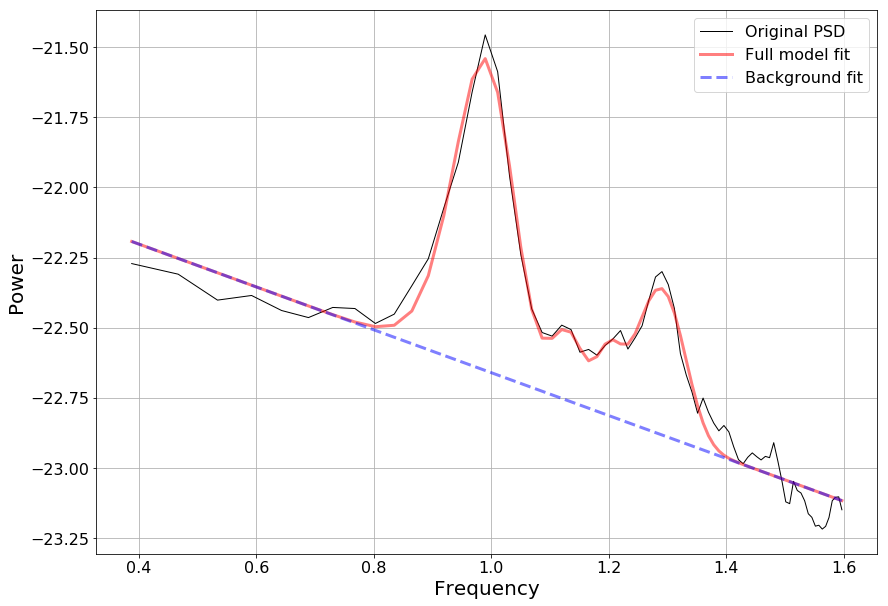

In [4]:
# Initialize FOOOF model
fm = FOOOF()

# Set the frequency range upon which to fit FOOOF
freq_range = [2, 40]

# Run FOOOF model - calculates model, plots, and prints parameters
#  Calling model necessarily requires providing the frequency vector, psd data, and frequency range to fit
#  You can also (optionally) specify whether to plot the result in log-log space (defaults to False: semi-log space)
fm.model(freqs, psd, freq_range, plt_log=True)

In [5]:
# Alternatively, just fit the model with FOOOF.fit()
fm.fit(freqs, psd, freq_range)

# After fitting (with .model() or .fit()), plotting and parameter fitting can be called independently:
# fm.plot()
# fm.print_params()


FOOOF WARNING: Lower-bound Bandwidth limit is ~= the frequency resolution. 
   This may lead to overfitting of small bandwidth oscillations.



### FOOOF Results

In [6]:
# Background params 
print('Background Parameters: \n', fm.background_params_, '\n')

# Oscillation parameters
print('Oscillation Parameters: \n', fm.oscillation_params_, '\n')

Background Parameters: 
 [-21.89682937   0.76346864] 

Oscillation Parameters: 
 [[  9.74716521   1.11125396   2.28154043]
 [ 13.46025653   0.24785595   1.68052342]
 [ 15.81191698   0.24964902   1.55741871]
 [ 19.48856681   0.52143303   3.7670429 ]] 



### Notes on Interpreting Oscillation Parameters

Note that the oscillation parameters that are returned are not exactly the same as the parameters of the gaussians used internally to fit the oscillations. 

Specifically:
- CF is the mean parameter of the gaussian
- Amp is the amplitude of the model fit above the background slope fit [1]
- BW is 2 * the standard deviation of the gaussian [2]

[1] Since the gaussians are fit together, the amplitude of the gaussians can only be interpreted with respect to all other oscillations, making gaussian amplitude uninterpretable in isolation.

[2] Standard deviation is '1 sided', returned BW is '2 sided'.

In [7]:
# There is also convenience method to gather model results 
bg_params, osc_params, r_squared, fit_error = fm.get_params()

In [8]:
# Check the r^2 and error of the model fit
print('R-squared: \n', fm.r2_)
print('Fit error: \n', fm.error_)

R-squared: 
 0.978171067705
Fit error: 
 0.0480353593963


### Note on Model Fit Error

FOOOF calculates the model fit error as the R^2 error between the full psd_fit and the original PSD, and these scores cna be used to assess how the model is performing.

Note, however, that FOOOF is NOT optimized to minimize this fit error at all costs. To do so typically results in fitting a large number of gaussian processes, in a way that overfits noise. The purpose of FOOOF is to measure PSD slope, and regions of oscillatory processes. As much as possible, FOOOF is tuned to only fit gaussians to regions in which there is power over and above the noise of the background process, in which an expert human rater would consider there to be an oscillatory 'bump'. 

Given this, while high R^2 error may indicate a poor model fit, very low R^2 error may also indicate a PSD that is overfit, in which case the oscillation parameters from the model may not accurately reflect oscillatory regions. 

### Description of FOOOF methods and parameters

FOOOF follows the Python convention in which all user exposed settings, data, and methods are directly accessible through the object, where as 'hidden' ones have a leading underscore.

The FOOOF object contents consist of 4 main components:
- Settings (attributes)
    - User exposed settings are all set in object initialization. 
    - There are some internal settings that are not exposed at initialization. These settings are unlikely to need to be accessed by the user, but can be if desired - they are  all defined and documented in init, there should be no other settings, or 'magic numbers' in any other parts of the code.
- Data (attributes)
    - FOOOF stores the frequency vector, power spectrum, frequency range, and frequency resolution.
        - fm.freqs, fm.psd, fm.freq_range, fm.freq_res
    - During the fit procedure, interim data variable are created and used. underscore. 
- Results (attributes)
    - FOOOF follows the scipy convention in that any attributes that are result from fitting to the data are indicated by a trailing underscore
        - fm.background\_params_, fm.oscillation\_params\_, fm.psd\_fit\_, fm.r2\_, fm.error\_
- Functions (methods)
    - Functions that operate on the FOOOF object data.
    - In addition to the exposed methods, there are some internal methods called in the fitting procedure. These methods should not be called independently, as they may depend on internal state as defined from other methods. 

## FOOOF Settings

With default settings, FOOOF is minimally constrained. It defaults as such since there are not universal settings that work across all different dataset modalities. Appropriate settings also vary with PSD quality (noise, or effectively, the smoothness of the PSD), and frequency ranges. 

For any given dataset, FOOOF will likely need some tuning of parameters for optimal performance. 

To do so, we suggest using a combination of the following considerations:
- A priori constraints, given your data, such as the number of oscillations you expect to extract
- Qualitative analysis, guided by examing the the plotted model fit results, as compared to input data
- Quantitative analysis, considering the model fit and error (however, see note at the bottom regarding interpreting model fit error)

Tuning FOOOF is an imperfect art, and should be done carefully, as assumptions built into the settings chosen will impact the model results. For this reason, FOOOF settings should not be changed between PSDs (across channels, trials, or subjects), if they are to be meaningfully compared. We recommend 

### Options

At initialization, you have the following settings available:

#### bandwidth_limits (Hz)

Enforced limits on the bandwidths of extracted oscillations, given as a list of [minimum bandwidth, maximum bandwidth]. We recommend bandwidths at last twice the frequency resolution of the power spectrum.

Default: [0.5, 12]

#### max_n_oscs (int)

The maximum number of oscillations that can be extracted from a given PSD. FOOOF will halt searching for new oscillations when this number is reached. Note that FOOOF extracts oscillations iteratively by amplitude (over and above the background), and so this approach should extract the _n_ largest oscillations. 

Default: infinite

#### amp_std_thresh (in units of standard deviation)

The threshold, in terms of standard deviation of the background removed power spectrum, above which a data point must pass to be considered a candidate oscillation. 

Default: 2.0

#### min_amp (in units of the psd)

The minimum amplitude, above the background fit, that an oscillation must have to be extracted in the initial fit stage. This setting can be useful for datasets in which their may be flat PSDs, since in this case the standard deviation may be very low, leading to overfitting of small bumps as oscillations. Note that because this constraint is enforced during oscillation search, returned oscillations are not guaranteed to surpass this value in amplitude.

Default: 0

#### fit_knee (boolean)

Whether to fit a 'knee' parameter in the log-lorentzian background fit. 

Default: False

### A note on amplitudes

Note that there are two different parameters controlling FOOOF halting its search for oscillations based on amplitude. By default, there is no minimum absolute amplitude, but FOOOF will halt when new potential oscillations fail to pass the threshold, defined in units of standard deviation over and above the background. If both are defined, FOOOF will halt finding new oscillations when candidate fails to pass either the minimum amplitude, or the threshold. 


### Tuning FOOOF

Most commonly, FOOOF will overfit, being overzealous at fitting small noisy bumps as oscillations. For a given dataset, a combination of increasing the minimum bandwidth, increasing one or both of the amplitude settings, and setting an upper limit on the possible number of oscillations can assist in making FOOOF more conservative in what it defines as an oscillation.

### Updating Settings

If you wish to change these settings, re-initialize the FOOOF object with new settings. Simply resetting the relevant attribute may not appropriately propragate the value, and may fail (either by erroring out, or not applying the settings properly during fit and returning erroneous results). 

In [9]:
# You can check all the user defined FOOOF settings with check_settings
#  The description parameter prints out a full description. A shorter summary is printed when False. 
fm.check_settings(description=True)

FOOOF SETTINGS:
Fit Knee:  False
	Whether to fit a knee parameter in background fitting.
Bandwidth Limits (Hz):  (0.5, 12.0)
	The possible range of bandwidths for extracted oscillations.
Max number of oscillations (int):  inf
	The maximum number of oscillations FOOOF will seek to extract.
Minimum amplitude (units of power):  0.0
	Minimum amplitude, above background, for an oscillation to be extracted.
Amplitude threshold (units of std deviation):  2.0
	Threshold at which to stop searching for oscillations.


### Fitting FOOOF, with different settings

In [10]:
# Load example data
freqs = np.load('freqs_2.npy')
psd = np.load('psd_2.npy')


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 2-40 Hz                      
                                 Frequency Resolution is 0.49 Hz 
                                  
                              Background Parameters (offset, slope):                                
                                          -21.4437, 1.0751                                          

                                      3 oscillations were found:                                     
                                 CF:   9.82, Amp:  0.728, BW:  3.00                                 
                                 CF:  13.04, Amp:  0.260, BW:  2.54                                 
                                 CF:  18.13, Amp:  0.151, BW:  4.63                                 

                                      R^2 of model fit is 0.9923                     

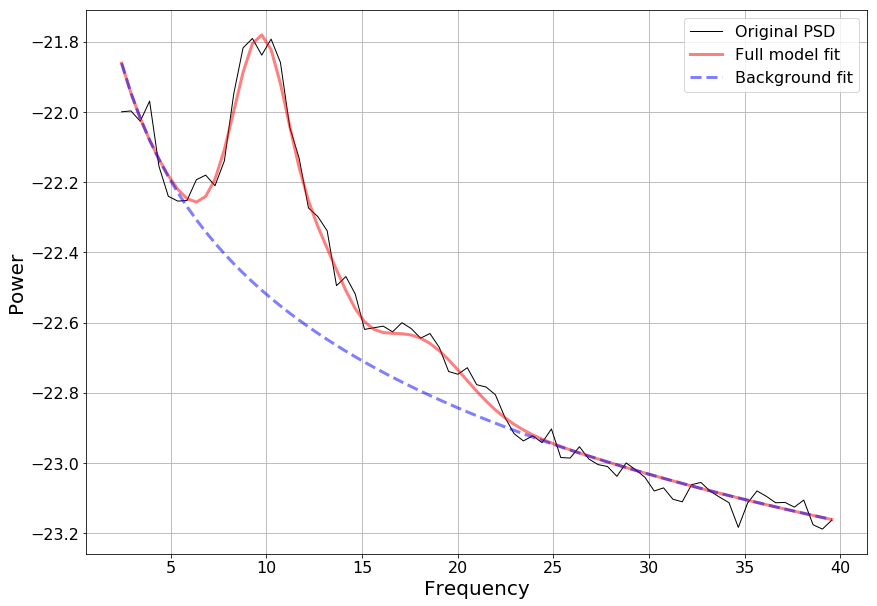

In [11]:
# Initialize FOOOF model, with different settings
fm = FOOOF(bandwidth_limits=(1, 8), max_n_oscs=6 , min_amp=0.15)

# Fit FOOOF
f_range = [2, 40]
fm.model(freqs, psd, f_range)

### Fitting FOOOF, with background knee

In [12]:
# Load example data (LFP)
freqs = np.load('freqs_lfp.npy')
psd = np.load('psd_lfp.npy')

In [ ]:
# Initialize FOOOF - setting to fit a knee
fm = FOOOF(bandwidth_limits=(2, 8), fit_knee=True)

# Fit FOOOF model
fm.model(freqs, psd, [2, 60], plt_log=True)